In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from random import sample
from collections import defaultdict
import graphviz 
import pandas

print('Loaded imports')

Loaded imports


In [2]:
h1b_df = pandas.read_csv('../data/h1b.csv')
perm_df = pandas.read_csv('../data/perm.csv', thousands=",")
housing_df = pandas.read_csv('../data/housing.csv')

# h1b_df = h1b_df[['FULL_TIME_POSITION', 'YEAR', 'PREVAILING_WAGE', 'CASE_STATUS']]
perm_df = perm_df[['naics_2007_us_code', 'wage_offer_from_9089', 'case_status', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'pw_level_9089']]
housing_columns = ['MSSubClass', 'MSZoning', 'LotArea', 'LotFrontage', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond', 'CentralAir']
housing_df = housing_df[housing_columns + ['SalePrice']]

# h1b_df = h1b_df.sample(n=100000)
print('Loaded dataframes')

/Users/philip/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded dataframes


In [3]:
# format data
datasetNum = 2

df = None
df_x = None
df_y = None
to_encode = []

classifed_names = None

if datasetNum == 0:
    df = h1b_df.copy()
    df_x = ['FULL_TIME_POSITION', 'YEAR', 'PREVAILING_WAGE']
    df_y = 'CASE_STATUS'
elif datasetNum == 1:
    df = perm_df.copy()
    df_x = [
        'wage_offer_from_9089',
        'naics_2007_us_code', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'employer_state', 'pw_level_9089']
    df_y = 'case_status'
    to_encode = [ 'country_of_citzenship', 'employer_state', 'pw_level_9089']
elif datasetNum == 2:
    df = housing_df.copy()
    df_x = housing_columns
    df_y = 'price_bracket'
    to_encode = housing_columns
    
le = preprocessing.LabelEncoder
encoderDict = defaultdict(le)

for column in to_encode:
    print('Encoding: ' + column)
    df[column] = df[column].dropna()
    df = df[df[column].notnull()]
    df[column] = encoderDict[column].fit_transform(df[column])
#     print(encoderDict[column].classes_)

if datasetNum == 0:
#     df['CITY'], df['STATE'] = df['WORKSITE'].str.split(',', 1).str
#     df['STATE'] = df['STATE'].str.strip()
#     df['STATE'].apply(str)

    df.loc[(df['FULL_TIME_POSITION'] == 'Y'), 'FULL_TIME_POSITION'] = 1
    df.loc[(df['FULL_TIME_POSITION'] == 'N'), 'FULL_TIME_POSITION'] = -1
    
    df = df[~df['CASE_STATUS'].str.contains("WITHDRAWN", na=True)]
    df = df[~df['CASE_STATUS'].str.contains("PENDING")]
    df = df[~df['CASE_STATUS'].str.contains("INVALIDATED")]
    df.loc[(df['CASE_STATUS'] == 'CERTIFIED'), 'CASE_STATUS'] = 1
    df.loc[(df['CASE_STATUS'] == 'CERTIFIED-WITHDRAWN'), 'CASE_STATUS'] = 1
    df.loc[(df['CASE_STATUS'] == 'DENIED'), 'CASE_STATUS'] = -1
    df.loc[(df['CASE_STATUS'] == 'REJECTED'), 'CASE_STATUS'] = -1
    
elif datasetNum == 1:
    df = df[~df['case_status'].str.contains("Withdrawn", na=False)]
    df.loc[(df['case_status'].str.contains('Certified', na=False)), 'case_status'] = 1
    df.loc[(df['case_status'].str.contains('Denied', na=False)), 'case_status'] = -1
    
    df.loc[(df['wage_offer_unit_of_pay_9089'].str.contains('yr', na=False)), 'wage_offer_unit_of_pay_9089'] = 2
    df.loc[(df['wage_offer_unit_of_pay_9089'].str.contains('hr', na=False)), 'wage_offer_unit_of_pay_9089'] = 1
elif datasetNum == 2:
    df['price_bracket'] = df['SalePrice'].copy().astype(int)
    
    classifed_names = []
    for bracket in range(0, 15):
        # Each bracket worth 40k
        bracket_width = 50000
        price_min = bracket * bracket_width
#         print(str(bracket) +': '+ str(price_min))
        price_max = price_min + bracket_width
        classifed_names.append(str(price_min) + '-' + str(price_max))
        df.loc[(df['SalePrice'] >= price_min), 'price_bracket'] = bracket
    
df = df.apply(lambda x: pandas.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))

print(df[:3])
# indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
# df = df[indices_to_keep]

print(df_x)
print(df_y)

print(df.columns)
print(df.dtypes)


Encoding: MSSubClass
Encoding: MSZoning
Encoding: LotArea
Encoding: LotFrontage
Encoding: Neighborhood
Encoding: BldgType
Encoding: HouseStyle
Encoding: OverallQual
Encoding: OverallCond
Encoding: YearBuilt
Encoding: ExterCond
Encoding: CentralAir
   MSSubClass  MSZoning  LotArea  LotFrontage  Neighborhood  BldgType  \
0           1         0      264           31             9         0   
1           0         0      409           21             9         0   
2           4         4      134           21            17         0   

   HouseStyle  OverallQual  OverallCond  YearBuilt  ExterCond  CentralAir  \
0           2            3            3         24          4           0   
1           2            1            1         50          4           0   
2           0            2            4         14          4           0   

   SalePrice  price_bracket  
0      34900              0  
1      35311              0  
2      37900              0  
['MSSubClass', 'MSZoning', 'Lo

In [4]:
df = df.dropna()  
# sample = df.sample(n=10000)

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)
print('Dataset size: ' + str(df.size))
print('Features: ' + str(df_x))
print('Trying to classify: ' + df_y)

X = df.loc[:, df_x]
y = df.loc[:, df_y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=0)


Dataset size: 16688
Features: ['MSSubClass', 'MSZoning', 'LotArea', 'LotFrontage', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond', 'CentralAir']
Trying to classify: price_bracket


In [8]:
# Decision Tree
for i in range(1,30 + 1): 
    clf = tree.DecisionTreeClassifier(max_depth=i, criterion='gini', splitter='best', min_samples_leaf=1)
    clf = clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    print(str(i) + ': ' + str(accuracy_score(y_test, y_predict))) 
    
    scores = cross_val_score(clf, X, y)
    print(str(i) + ': ' + str(scores.mean()))
#     dot_data = tree.export_graphviz(clf, out_file=None, 
#                          feature_names=df_x,  
#                          class_names=classifed_names,  
#                          filled=True, rounded=True,  
#                          special_characters=True)  
#     graph = graphviz.Source(dot_data).view()

1: 0.416201117318
1: 0.445467397353
2: 0.477653631285
2: 0.482495072092
3: 0.530726256983
3: 0.516823450004
4: 0.533519553073
4: 0.53455617672
5: 0.54748603352
5: 0.542933899837
6: 0.550279329609
6: 0.547980974165
7: 0.522346368715
7: 0.552853808765
8: 0.561452513966
8: 0.544469819905
9: 0.536312849162
9: 0.54702939439
10: 0.5
10: 0.53527213481
11: 0.502793296089
11: 0.525341570399
12: 0.491620111732
12: 0.511051675307
13: 0.480446927374
13: 0.511039143822
14: 0.494413407821
14: 0.522699903525
15: 0.469273743017
15: 0.52527137176
16: 0.474860335196
16: 0.519273355391
17: 0.472067039106
17: 0.513477755992
18: 0.491620111732
18: 0.510986504143
19: 0.463687150838
19: 0.514298355704
20: 0.474860335196
20: 0.511012204848
21: 0.466480446927
21: 0.510122044232
22: 0.491620111732
22: 0.517691061387
23: 0.463687150838
23: 0.507613233423
24: 0.463687150838
24: 0.510222933849
25: 0.449720670391
25: 0.523600719624
26: 0.480446927374
26: 0.528484209707
27: 0.469273743017
27: 0.514267664726
28: 0.48

In [9]:
from sklearn.ensemble import AdaBoostClassifier
estimators = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30,40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]
for estimator in estimators:
    clf = AdaBoostClassifier(n_estimators=estimator)
    clf = clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    print(str(estimator) + ': ' + str(accuracy_score(y_test, y_predict))) 
    
    scores = cross_val_score(clf, X, y)
    print(str(estimator) + ': ' + str(scores.mean()))

1: 0.416201117318
1: 0.445467397353
2: 0.379888268156
2: 0.459038220084
3: 0.379888268156
3: 0.471597919884
4: 0.379888268156
4: 0.470760398946
5: 0.379888268156
5: 0.471597919884
6: 0.379888268156
6: 0.470760398946
7: 0.379888268156
7: 0.471597919884
8: 0.379888268156
8: 0.470760398946
9: 0.379888268156
9: 0.471597919884
10: 0.379888268156
10: 0.470760398946
15: 0.379888268156
15: 0.472435440822
20: 0.379888268156
20: 0.470760398946
30: 0.379888268156
30: 0.470760398946
40: 0.379888268156
40: 0.470760398946
50: 0.379888268156
50: 0.470760398946
60: 0.379888268156
60: 0.470760398946
70: 0.379888268156
70: 0.470760398946
80: 0.379888268156
80: 0.470760398946
90: 0.379888268156
90: 0.470760398946
100: 0.379888268156
100: 0.470760398946
125: 0.379888268156
125: 0.471597919884
150: 0.379888268156
150: 0.470760398946
175: 0.379888268156
175: 0.471597919884
200: 0.379888268156
200: 0.470760398946
250: 0.379888268156
250: 0.470760398946
300: 0.379888268156
300: 0.470760398946
350: 0.379888268

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  

clf = MLPClassifier(solver='sgd', activation='relu', max_iter=1500, alpha=0.001, batch_size=200, hidden_layer_sizes=(150, ), random_state=42)

scaler = StandardScaler()
scaler.fit(X_train) 
X_train_new = scaler.transform(X_train)
X_test_new = scaler.transform(X_test)
clf.fit(X_train_new, y_train)
y_predict = clf.predict(X_test_new)
print(str(accuracy_score(y_test, y_predict)))

0.564245810056



learning on dataset Test
training: constant learning-rate
Training set score: 0.554530
Training set loss: 1.135199
training: constant with momentum
Training set score: 0.598154
Training set loss: 1.078860
training: constant with Nesterov's momentum
Training set score: 0.614933
Training set loss: 1.018877
training: inv-scaling learning-rate
Training set score: 0.369128
Training set loss: 1.694928
training: inv-scaling with momentum


/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.473154
Training set loss: 1.402883
training: inv-scaling with Nesterov's momentum
Training set score: 0.161913
Training set loss: 2.185332
training: adam
Training set score: 0.598993
Training set loss: 1.000350


NameError: name 'ax' is not defined

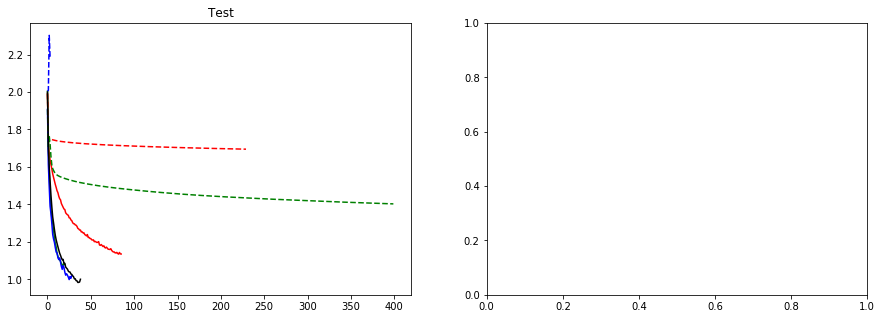

In [13]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)
    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(verbose=0, random_state=0,
                            max_iter=max_iter, **param)
        mlp.fit(X, y)
        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
            ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# load / generate some toy datasets

plot_on_dataset(X, y, axes.ravel()[0], 'Test')

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

In [14]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
scores = cross_val_score(clf, X, y)
print(str(scores.mean()))

clf = svm.SVC(kernel='linear')
scores = cross_val_score(clf, X, y)
print(str(scores.mean()))

0.393467074149
0.577397647552


In [18]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

print('Running knn')
h = .02  # step size in the mesh

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

k_vals = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50]

for weight in ['uniform', 'distance']:
    for k in k_vals:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(k, weights=weight)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        print(str(k) + ':' + weight + ': ' + str(accuracy_score(y_test, y_predict))) 
        
        scores = cross_val_score(clf, X, y)
        print(str(k) + ':' + weight + ': ' + str(scores.mean()))


Running knn
1:uniform: 0.427374301676
1:uniform: 0.437714723255
2:uniform: 0.45530726257
2:uniform: 0.451222888559
3:uniform: 0.45251396648
3:uniform: 0.454693296891
4:uniform: 0.438547486034
4:uniform: 0.466505709888
5:uniform: 0.45530726257
5:uniform: 0.473178938419
10:uniform: 0.458100558659
10:uniform: 0.454700800902
15:uniform: 0.472067039106
15:uniform: 0.474018335359
20:uniform: 0.444134078212
20:uniform: 0.467363904057
25:uniform: 0.441340782123
25:uniform: 0.474889698748
30:uniform: 0.441340782123
30:uniform: 0.463170033624
50:uniform: 0.418994413408
50:uniform: 0.437861386275
1:distance: 0.427374301676
1:distance: 0.437714723255
2:distance: 0.427374301676
2:distance: 0.439394154871
3:distance: 0.444134078212
3:distance: 0.473049834359
4:distance: 0.469273743017
4:distance: 0.476461337269
5:distance: 0.480446927374
5:distance: 0.482362853761
10:distance: 0.494413407821
10:distance: 0.492322233148
15:distance: 0.5
15:distance: 0.497389980707
20:distance: 0.5
20:distance: 0.5007